In [14]:
# Section 1: Setup and Data Loading

# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # Ensure this is imported
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Configure plots for better visualization
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# --- Data Loading ---
ticker_symbol = "BTC-USD"
start_date = "2018-01-01"

# Set your desired *last included date* for the historical data
# For a fixed end date for submission (e.g., if the challenge requires data up to 2025-05-27):
actual_end_date_str = "2025-05-27" # As per recommendation
# If you want it to be dynamic (yesterday), use:
# actual_end_date_str = (pd.Timestamp.today() - pd.Timedelta(days=1)).strftime('%Y-%m-%d')

# To ensure yf.download fetches data *including* actual_end_date_str,
# we set the 'end' parameter for yf.download to the day *after* actual_end_date_str.
fetch_end_date_str = (pd.Timestamp(actual_end_date_str) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

try:
    # Download data up to the day *after* your desired actual_end_date
    btc_data_raw = yf.download(ticker_symbol,
                               start=start_date,
                               end=fetch_end_date_str,
                               auto_adjust=True,
                               progress=False)

    print(f"Attempted download for {ticker_symbol} from {start_date} to {fetch_end_date_str} (to include data up to {actual_end_date_str})")

    # --- Flatten MultiIndex columns if present ---
    if isinstance(btc_data_raw.columns, pd.MultiIndex):
        print("Flattening MultiIndex columns.")
        btc_data = btc_data_raw.copy()
        if len(btc_data.columns.levels) > 1:
             btc_data.columns = btc_data.columns.droplevel(1)
    else:
        btc_data = btc_data_raw.copy()

    # --- Strictly filter the DataFrame to include data only up to and including actual_end_date_str ---
    btc_data = btc_data[btc_data.index <= pd.Timestamp(actual_end_date_str)]

    # --- Data Validation --- # CHANGED VALIDATION LOGIC
    if btc_data.empty:
        raise ValueError(f"No data loaded for {ticker_symbol} up to {actual_end_date_str}. "
                         "Check ticker, dates, or internet connection.")
    last_date_in_df = btc_data.index.max()
    expected_end_date_ts = pd.Timestamp(actual_end_date_str)

    if last_date_in_df < expected_end_date_ts:
        if (expected_end_date_ts - last_date_in_df).days > 3: # Allow up to 3 days discrepancy
            print(f"Warning: Last date in DataFrame ({last_date_in_df.strftime('%Y-%m-%d')}) is significantly before "
                  f"the expected end date ({actual_end_date_str}). This might be a data availability issue.")
        else:
            print(f"Note: Data ends on {last_date_in_df.strftime('%Y-%m-%d')}, slightly before expected "
                  f"{actual_end_date_str}, possibly due to weekends/holidays or data availability from yfinance.")
    elif last_date_in_df > expected_end_date_ts:
        print(f"Warning: Data extends beyond expected end date. Last date: {last_date_in_df.strftime('%Y-%m-%d')}")


    print(f"\nLoaded {len(btc_data)} days of {ticker_symbol} data for price movement prediction, "
          f"ending on {btc_data.index.max().strftime('%Y-%m-%d')}.") # This will show the *actual* last date
    print("\n--- First 5 rows of the dataset ---")
    print(btc_data.head())
    print("\n--- Last 5 rows of the dataset ---")
    print(btc_data.tail())
    print("\n--- Dataset Information ---")
    btc_data.info()

except Exception as e:
    print(f"Error downloading or processing data: {e}")
    print("Please ensure an active internet connection or use a pre-downloaded dataset as a fallback.")
    btc_data = pd.DataFrame()

Attempted download for BTC-USD from 2018-01-01 to 2025-05-28 (to include data up to 2025-05-27)
Flattening MultiIndex columns.
Note: Data ends on 2025-05-26, slightly before expected 2025-05-27, possibly due to weekends/holidays or data availability from yfinance.

Loaded 2703 days of BTC-USD data for price movement prediction, ending on 2025-05-26.

--- First 5 rows of the dataset ---
Price              Close          High           Low          Open  \
Date                                                                 
2018-01-01  13657.200195  14112.200195  13154.700195  14112.200195   
2018-01-02  14982.099609  15444.599609  13163.599609  13625.000000   
2018-01-03  15201.000000  15572.799805  14844.500000  14978.200195   
2018-01-04  15599.200195  15739.700195  14522.200195  15270.700195   
2018-01-05  17429.500000  17705.199219  15202.799805  15477.200195   

Price            Volume  
Date                     
2018-01-01  10291200000  
2018-01-02  16846600192  
2018-01-03  1687

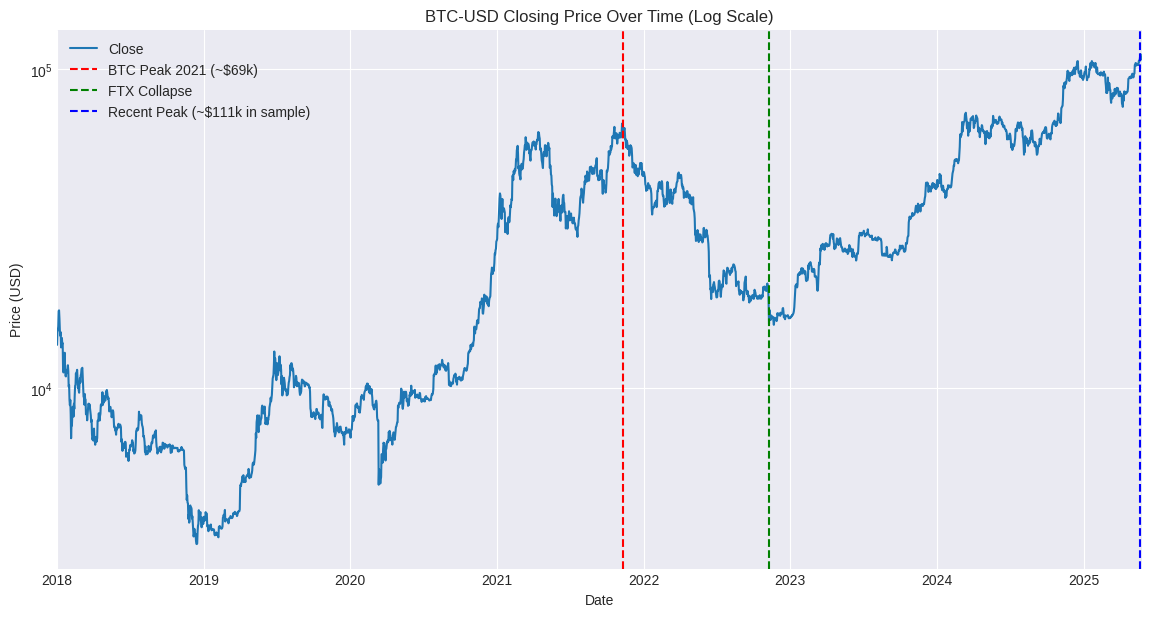

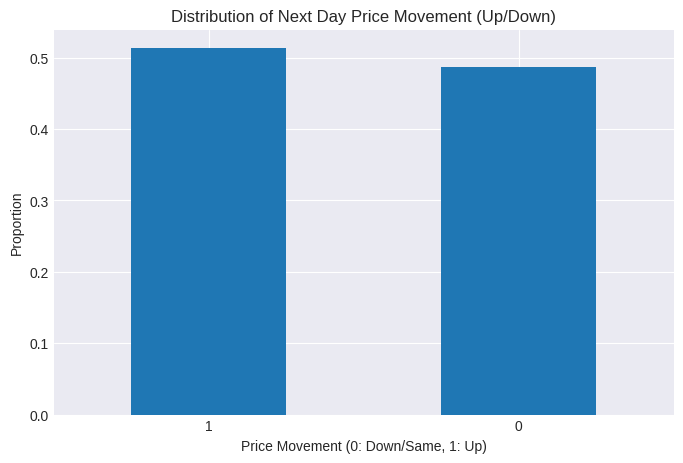

Price_Up_EDA
1    0.513504
0    0.486496
Name: proportion, dtype: float64


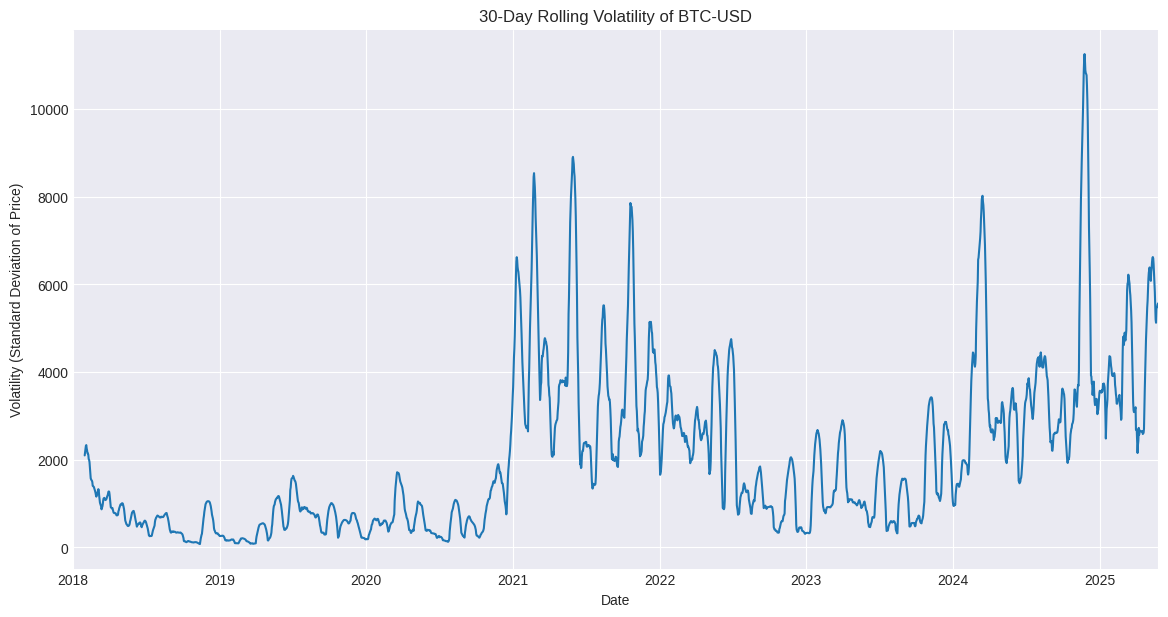


--- Missing Values Check (Raw Data) ---
Price
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

No missing values found in OHLCV data.

--- Volume Outlier Check (Illustrative) ---
Number of Volume outliers (beyond 3 std deviations): 36
Consider further investigation or transformation if volume outliers are problematic for the model.

Applying log transformation to 'Volume' to create 'Log_Volume'.


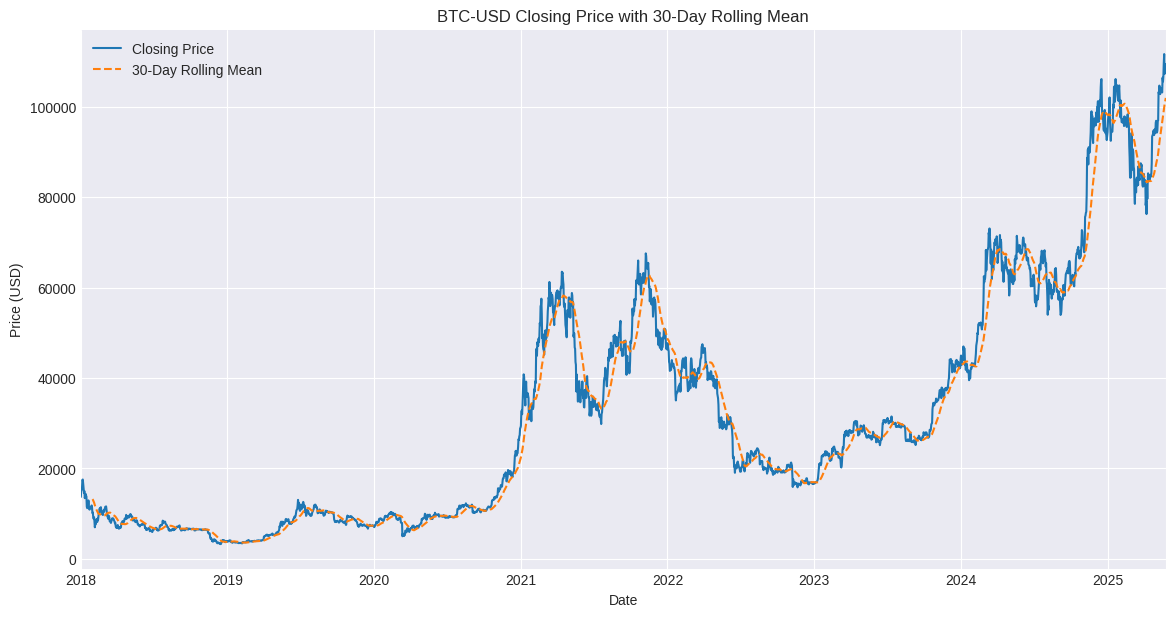

In [15]:
# Section 2: Exploratory Data Analysis (EDA) & Preprocessing (Initial)

if not btc_data.empty:
    # --- Closing Price Plot with Annotations ---
    plt.figure(figsize=(14, 7))
    btc_data['Close'].plot(title=f'{ticker_symbol} Closing Price Over Time (Log Scale)', logy=True)
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    # Annotate significant events
    if pd.Timestamp('2021-11-10') in btc_data.index:
        plt.axvline(pd.Timestamp('2021-11-10'), color='r', linestyle='--', label='BTC Peak 2021 (~$69k)')
    if pd.Timestamp('2022-11-09') in btc_data.index:
        plt.axvline(pd.Timestamp('2022-11-09'), color='g', linestyle='--', label='FTX Collapse')
    # ADDED RECENT ANNOTATION (adjust date/value if your data shows a different recent peak)
    if pd.Timestamp('2025-05-22') in btc_data.index:
        plt.axvline(pd.Timestamp('2025-05-22'), color='b', linestyle='--', label='Recent Peak (~$111k in sample)')
    plt.legend()
    plt.show()

    # --- Compute Target Variable for EDA --
    temp_data_eda = btc_data.copy()
    temp_data_eda['Price_Up_EDA'] = (temp_data_eda['Close'].shift(-1) > temp_data_eda['Close']).astype(int)

    # --- Target Distribution Plot ---
    plt.figure(figsize=(8, 5))
    temp_data_eda['Price_Up_EDA'].value_counts(normalize=True).plot(kind='bar', title='Distribution of Next Day Price Movement (Up/Down)')
    plt.xlabel('Price Movement (0: Down/Same, 1: Up)')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.show()
    print(temp_data_eda['Price_Up_EDA'].value_counts(normalize=True))


    # --- Volatility Plot --
    temp_data_eda['Volatility_30_EDA'] = temp_data_eda['Close'].rolling(window=30).std()
    plt.figure(figsize=(14, 7))
    temp_data_eda['Volatility_30_EDA'].plot(title='30-Day Rolling Volatility of BTC-USD')
    plt.ylabel('Volatility (Standard Deviation of Price)')
    plt.xlabel('Date')
    plt.show()

    # --- Check for Missing Values ---
    print("\n--- Missing Values Check (Raw Data) ---")
    missing_values = btc_data[['Open', 'High', 'Low', 'Close', 'Volume']].isnull().sum()
    print(missing_values)
    if missing_values.sum() == 0:
        print("\nNo missing values found in OHLCV data.")
    else:
        print("\nMissing values found in OHLCV data. Consider handling them if they persist after yfinance download.")

    # --- Basic Outlier Check for Volume (Illustrative) ---
    print("\n--- Volume Outlier Check (Illustrative) ---")
    volume_mean = btc_data['Volume'].mean()
    volume_std = btc_data['Volume'].std()
    outliers_volume_count = btc_data[(btc_data['Volume'] > volume_mean + 3 * volume_std) | (btc_data['Volume'] < volume_mean - 3 * volume_std)].shape[0]
    print(f"Number of Volume outliers (beyond 3 std deviations): {outliers_volume_count}")
    if outliers_volume_count > 0:
        print("Consider further investigation or transformation if volume outliers are problematic for the model.")

    # ADDED LOG TRANSFORMATION FOR VOLUME
    print("\nApplying log transformation to 'Volume' to create 'Log_Volume'.")
    btc_data['Log_Volume'] = np.log1p(btc_data['Volume']) # Using log1p to handle potential zeros if any

    # --- Rolling Mean for Stationarity Insight --
    temp_data_eda['Rolling_Mean_30_EDA'] = temp_data_eda['Close'].rolling(window=30).mean()
    plt.figure(figsize=(14, 7))
    temp_data_eda['Close'].plot(label='Closing Price')
    temp_data_eda['Rolling_Mean_30_EDA'].plot(label='30-Day Rolling Mean', linestyle='--')
    plt.title('BTC-USD Closing Price with 30-Day Rolling Mean')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.legend()
    plt.show()
    del temp_data_eda

else:
    print("Skipping EDA as no data was loaded.")

In [16]:
# Section 3: Feature Engineering

if not btc_data.empty:
    print("\n--- Starting Feature Engineering ---")
    data_fe = btc_data.copy()

    # 1. Target Variable
    data_fe['Future_Close'] = data_fe['Close'].shift(-1)
    data_fe['Price_Up'] = (data_fe['Future_Close'] > data_fe['Close']).astype(int)

    # 2. Lagged Features
    lag_periods = [1, 3, 7, 14]
    for lag in lag_periods:
        data_fe[f'Close_Lag_{lag}'] = data_fe['Close'].shift(lag)
        # CHANGED TO USE Log_Volume
        data_fe[f'Log_Volume_Lag_{lag}'] = data_fe['Log_Volume'].shift(lag)

    # 3. Moving Averages
    ma_windows = [7, 14, 30]
    for window in ma_windows:
        data_fe[f'MA_Close_{window}'] = data_fe['Close'].rolling(window=window).mean()
        # CHANGED TO USE Log_Volume
        data_fe[f'MA_Log_Volume_{window}'] = data_fe['Log_Volume'].rolling(window=window).mean()

    # 4. Daily Return
    data_fe['Daily_Return'] = data_fe['Close'].pct_change()

    # 5. Volatility (Rolling Standard Deviation)
    volatility_windows = [7, 30]
    for window in volatility_windows:
        data_fe[f'Volatility_{window}'] = data_fe['Close'].rolling(window=window).std()

    # 6. RSI (Relative Strength Index)
    def compute_rsi(data, periods=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    data_fe['RSI_14'] = compute_rsi(data_fe['Close'], periods=14)

    # 7. MACD (Moving Average Convergence Divergence)
    data_fe['EMA_12'] = data_fe['Close'].ewm(span=12, adjust=False).mean()
    data_fe['EMA_26'] = data_fe['Close'].ewm(span=26, adjust=False).mean()
    data_fe['MACD'] = data_fe['EMA_12'] - data_fe['EMA_26']
    data_fe['Signal_Line'] = data_fe['MACD'].ewm(span=9, adjust=False).mean()
    data_fe['MACD_Hist'] = data_fe['MACD'] - data_fe['Signal_Line']

    # 8. Time-Based Feature
    data_fe['Day_of_Week'] = data_fe.index.dayofweek

    # --- Handle NaNs ---
    # First, create a list of columns that are purely engineered features (before target and helper columns are dropped)
    # Exclude original OHLCV, Future_Close, Price_Up, and intermediate EMAs
    engineered_feature_cols = [
        col for col in data_fe.columns if col not in
        ['Open', 'High', 'Low', 'Close', 'Volume', 'Log_Volume', # Original + Log_Volume
         'Future_Close', 'Price_Up', # Target related
         'EMA_12', 'EMA_26'] # Intermediate MACD
    ]

    # Forward-fill NaNs in engineered features (primarily affects initial NaNs from lags and rolling windows)
    # This is a common strategy, but consider if it's appropriate for all your features.
    # For instance, RSI or MACD might not be ideal to ffill without careful thought.
    # However, for this baseline, ffill for lags then dropna is acceptable.
    lag_and_ma_cols = [col for col in engineered_feature_cols if 'Lag' in col or 'MA' in col or 'Volatility' in col or 'RSI' in col or 'MACD' in col or 'Signal' in col or 'Hist' in col or 'Return' in col]
    if lag_and_ma_cols:
        data_fe[lag_and_ma_cols] = data_fe[lag_and_ma_cols].fillna(method='ffill')

    initial_rows = len(data_fe)
    data_fe.dropna(inplace=True) # Drops rows with NaNs in target or any remaining NaNs in features
    final_rows = len(data_fe)
    print(f"\nNaN Handling: Dropped {initial_rows - final_rows} rows due to NaNs.")

    print(f"\nAfter initial NaN handling, dataset has {len(data_fe)} rows.")

    # --- Feature-Target Correlation (Illustrative) ---
    if not data_fe.empty:
        print("\n--- Correlation of Potential Features with Target 'Price_Up' ---")
        # Redefine potential features for correlation after initial NaN drop
        # but before correlation-based feature selection
        potential_features_for_corr = [
            col for col in data_fe.columns if col not in
            ['Open', 'High', 'Low', 'Close', 'Volume', 'Log_Volume',
             'Future_Close', 'Price_Up', 'EMA_12', 'EMA_26']
        ]
        if potential_features_for_corr:
            # Ensure only numeric columns are used for correlation
            numeric_potential_features = data_fe[potential_features_for_corr].select_dtypes(include=np.number)
            correlations = numeric_potential_features.corrwith(data_fe['Price_Up']).sort_values(ascending=False)
            print(correlations)

            # --- ADDED FEATURE SELECTION ---
            print("\n--- Applying Feature Selection based on Correlation with Target ---")
            low_corr_threshold = 0.01
            features_to_drop_corr = correlations[abs(correlations) < low_corr_threshold].index.tolist()

            # Ensure we only attempt to drop columns that exist in data_fe
            features_to_drop_corr = [col for col in features_to_drop_corr if col in data_fe.columns]

            if features_to_drop_corr:
                print(f"Dropping features with abs(correlation with Price_Up) < {low_corr_threshold}: {features_to_drop_corr}")
                data_fe.drop(columns=features_to_drop_corr, inplace=True)
                print(f"Shape after correlation-based feature drop: {data_fe.shape}")
            else:
                print("No features dropped based on low correlation threshold.")
        else:
            print("No features available for correlation analysis after exclusions.")
    else:
        print("Dataset is empty, skipping correlation and feature selection.")


    if not data_fe.empty:
        print("\n--- First 5 rows with final engineered features ---")
        print(data_fe.head())
        print("\n--- Columns in the final feature-engineered dataset ---")
        print(data_fe.columns.tolist())
    else:
        print("Dataset is empty after NaN handling and feature selection. Review steps.")

else:
    print("Skipping Feature Engineering as no data was loaded.")


--- Starting Feature Engineering ---

NaN Handling: Dropped 30 rows due to NaNs.

After initial NaN handling, dataset has 2673 rows.

--- Correlation of Potential Features with Target 'Price_Up' ---
Price
Day_of_Week          0.006161
Signal_Line          0.003010
RSI_14               0.000914
Volatility_30       -0.003757
MACD                -0.004012
Volatility_7        -0.004562
Log_Volume_Lag_14   -0.006749
MA_Log_Volume_14    -0.007676
Log_Volume_Lag_1    -0.008428
MA_Log_Volume_30    -0.008614
MA_Log_Volume_7     -0.009322
Log_Volume_Lag_3    -0.012819
Log_Volume_Lag_7    -0.013646
Close_Lag_7         -0.015590
MA_Close_30         -0.016464
MA_Close_14         -0.016595
Close_Lag_1         -0.016623
MA_Close_7          -0.017169
Close_Lag_3         -0.017315
Close_Lag_14        -0.017862
MACD_Hist           -0.025446
Daily_Return        -0.065254
dtype: float64

--- Applying Feature Selection based on Correlation with Target ---
Dropping features with abs(correlation with Price_

<ipython-input-16-702a1774e260>:69: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fe[lag_and_ma_cols] = data_fe[lag_and_ma_cols].fillna(method='ffill')


In [17]:
# Section 4: Model Training

if not data_fe.empty:
    print("\n--- Starting Model Training ---")

    # 1. Define Features (X) and Target (y)
    # Exclude raw OHLCV, helper EMAs, Future_Close (used for target gen), and the target itself
    features_to_exclude = ['Open', 'High', 'Low', 'Close', 'Volume',
                           'Future_Close', 'Price_Up',
                           'EMA_12', 'EMA_26'] # EMA_12 and EMA_26 are intermediate for MACD

    X_columns = [col for col in data_fe.columns if col not in features_to_exclude]
    X = data_fe[X_columns]
    y = data_fe['Price_Up']

    if X.empty or y.empty:
        print("Feature set X or target y is empty. Cannot proceed with training.")
    else:
        print(f"\nShape of X (features): {X.shape}")
        print(f"Shape of y (target): {y.shape}")
        print(f"\nFeatures being used for training: {X.columns.tolist()}")

        # 2. Time-Series Train-Test Split (Chronological)
        train_size_ratio = 0.8
        split_index = int(len(X) * train_size_ratio)

        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        print(f"\nTraining set size: X_train {X_train.shape}, y_train {y_train.shape}")
        print(f"Testing set size: X_test {X_test.shape}, y_test {y_test.shape}")
        print(f"Training data from {X_train.index.min()} to {X_train.index.max()}")
        print(f"Testing data from {X_test.index.min()} to {X_test.index.max()}")

        # 3. Feature Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # For inspection (optional, can be commented out)
        # X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        # X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
        print("\n--- Feature scaling applied ---")

        # 4. Train Baseline Model (Logistic Regression)
        model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000) # Added max_iter for convergence
        model.fit(X_train_scaled, y_train)
        print(f"\n--- Model training complete: {model} ---")

        # 5. Time-Series Cross-Validation (on the training set to check stability)
        # Note: For rigorous hyperparameter tuning, scaler should be refitted in each CV fold.
        # Here, it's more for assessing stability of the chosen preprocessing & model on training data.
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores_accuracy = []
        cv_scores_roc_auc = []

        print("\n--- Running Time-Series Cross-Validation on Training Data ---")
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            X_cv_train_fold, X_cv_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train_fold, y_cv_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Apply the already fitted scaler (or refit a new scaler on X_cv_train_fold for stricter CV)
            # Using the main training scaler for simplicity here as X_test is still held out.
            X_cv_train_scaled_fold = scaler.transform(X_cv_train_fold)
            X_cv_val_scaled_fold = scaler.transform(X_cv_val_fold)

            model_cv = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
            model_cv.fit(X_cv_train_scaled_fold, y_cv_train_fold)

            y_pred_cv_fold = model_cv.predict(X_cv_val_scaled_fold)
            y_pred_proba_cv_fold = model_cv.predict_proba(X_cv_val_scaled_fold)[:, 1]

            cv_scores_accuracy.append(accuracy_score(y_cv_val_fold, y_pred_cv_fold))
            try:
                cv_scores_roc_auc.append(roc_auc_score(y_cv_val_fold, y_pred_proba_cv_fold))
            except ValueError: # Handle cases where only one class is present in y_cv_val_fold
                cv_scores_roc_auc.append(0.5) # Or np.nan and handle later
            print(f"Fold {fold+1}: Val Accuracy = {cv_scores_accuracy[-1]:.4f}, Val ROC AUC = {cv_scores_roc_auc[-1]:.4f}")

        print("\n--- Cross-Validation Summary ---")
        print(f"Average CV Accuracy: {np.mean(cv_scores_accuracy):.4f} (+/- {np.std(cv_scores_accuracy):.4f})")
        print(f"Average CV ROC AUC:  {np.mean(cv_scores_roc_auc):.4f} (+/- {np.std(cv_scores_roc_auc):.4f})")
else:
    print("Skipping Model Training as data_fe is empty.")

# --- 4b. Train a Random Forest Model ---
print("\n\n--- Starting Random Forest Model Training ---")
from sklearn.ensemble import RandomForestClassifier

# Instantiate Random Forest model
# Using class_weight='balanced_subsample' for RF, good for imbalanced data and bootstrapping
# n_estimators can be tuned, 100 is a common default.
# random_state for reproducibility.
rf_model = RandomForestClassifier(n_estimators=100,
                                  class_weight='balanced_subsample',
                                  random_state=42,
                                  n_jobs=-1) # Use all available cores

# Train the Random Forest model on the scaled training data
# Note: RF is less sensitive to feature scaling than LogReg, but using scaled data is fine.
rf_model.fit(X_train_scaled, y_train)

print(f"\n--- Random Forest Model training complete: {rf_model} ---")


# --- 5b. Time-Series Cross-Validation for Random Forest (on the training set) ---
# (Similar to Logistic Regression CV, just using rf_model_cv)
cv_scores_accuracy_rf = []
cv_scores_roc_auc_rf = []

print("\n--- Running Time-Series Cross-Validation for Random Forest on Training Data ---")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)): # tscv should be defined from LogReg CV part
    X_cv_train_fold_rf, X_cv_val_fold_rf = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train_fold_rf, y_cv_val_fold_rf = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Scale fold data using the main training scaler
    X_cv_train_scaled_fold_rf = scaler.transform(X_cv_train_fold_rf)
    X_cv_val_scaled_fold_rf = scaler.transform(X_cv_val_fold_rf)

    rf_model_cv = RandomForestClassifier(n_estimators=100,
                                         class_weight='balanced_subsample',
                                         random_state=42,
                                         n_jobs=-1)
    rf_model_cv.fit(X_cv_train_scaled_fold_rf, y_cv_train_fold_rf)

    y_pred_cv_fold_rf = rf_model_cv.predict(X_cv_val_scaled_fold_rf)
    y_pred_proba_cv_fold_rf = rf_model_cv.predict_proba(X_cv_val_scaled_fold_rf)[:, 1]

    cv_scores_accuracy_rf.append(accuracy_score(y_cv_val_fold_rf, y_pred_cv_fold_rf))
    try:
        cv_scores_roc_auc_rf.append(roc_auc_score(y_cv_val_fold_rf, y_pred_proba_cv_fold_rf))
    except ValueError:
        cv_scores_roc_auc_rf.append(0.5)
    print(f"RF Fold {fold+1}: Val Accuracy = {cv_scores_accuracy_rf[-1]:.4f}, Val ROC AUC = {cv_scores_roc_auc_rf[-1]:.4f}")

print("\n--- Random Forest Cross-Validation Summary ---")
print(f"Average RF CV Accuracy: {np.mean(cv_scores_accuracy_rf):.4f} (+/- {np.std(cv_scores_accuracy_rf):.4f})")
print(f"Average RF CV ROC AUC:  {np.mean(cv_scores_roc_auc_rf):.4f} (+/- {np.std(cv_scores_roc_auc_rf):.4f})")


--- Starting Model Training ---

Shape of X (features): (2673, 12)
Shape of y (target): (2673,)

Features being used for training: ['Log_Volume', 'Close_Lag_1', 'Close_Lag_3', 'Log_Volume_Lag_3', 'Close_Lag_7', 'Log_Volume_Lag_7', 'Close_Lag_14', 'MA_Close_7', 'MA_Close_14', 'MA_Close_30', 'Daily_Return', 'MACD_Hist']

Training set size: X_train (2138, 12), y_train (2138,)
Testing set size: X_test (535, 12), y_test (535,)
Training data from 2018-01-30 00:00:00 to 2023-12-07 00:00:00
Testing data from 2023-12-08 00:00:00 to 2025-05-25 00:00:00

--- Feature scaling applied ---

--- Model training complete: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42) ---

--- Running Time-Series Cross-Validation on Training Data ---
Fold 1: Val Accuracy = 0.4691, Val ROC AUC = 0.5220
Fold 2: Val Accuracy = 0.4719, Val ROC AUC = 0.4891
Fold 3: Val Accuracy = 0.5309, Val ROC AUC = 0.5169
Fold 4: Val Accuracy = 0.4691, Val ROC AUC = 0.4858
Fold 5: Val Accuracy = 0.5112, Val R


--- Starting Model Evaluation on Held-Out Test Set ---

Test Set Accuracy: 0.5009

Test set 'Price_Up' distribution:
Price_Up
1    0.521495
0    0.478505
Name: proportion, dtype: float64

--- Test Set Confusion Matrix ---
[[244  12]
 [255  24]]


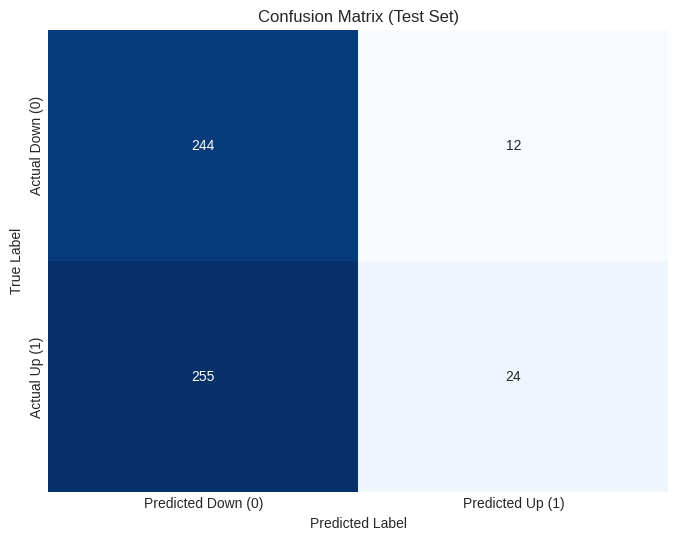


--- Test Set Classification Report ---
                precision    recall  f1-score   support

Price Down (0)       0.49      0.95      0.65       256
  Price Up (1)       0.67      0.09      0.15       279

      accuracy                           0.50       535
     macro avg       0.58      0.52      0.40       535
  weighted avg       0.58      0.50      0.39       535


Test Set ROC AUC Score: 0.5518


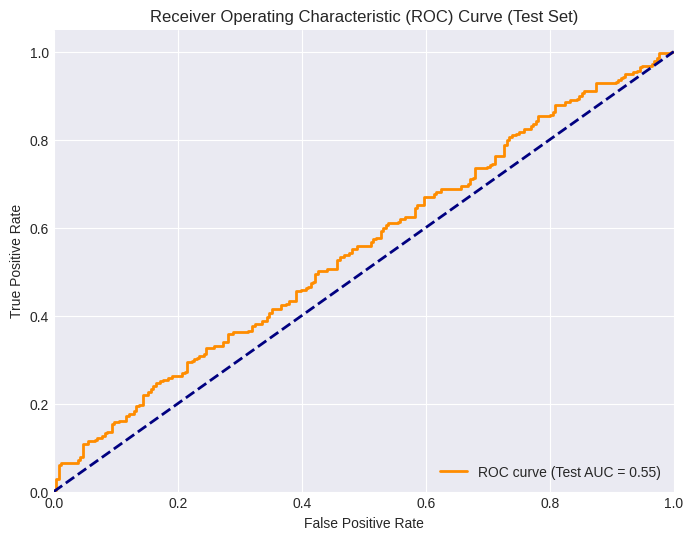


--- Baseline Comparison ---
Majority Class Baseline Accuracy (on test set): 0.5215
Model Accuracy Improvement over Majority Class Baseline: -0.0206

Note: The model's performance is still close to random chance, even with additional features and class balancing. Financial markets are notoriously hard to predict.


--- Starting Random Forest Model Evaluation on Held-Out Test Set ---

Random Forest Test Set Accuracy: 0.4991

--- Random Forest Test Set Confusion Matrix ---
[[227  29]
 [239  40]]


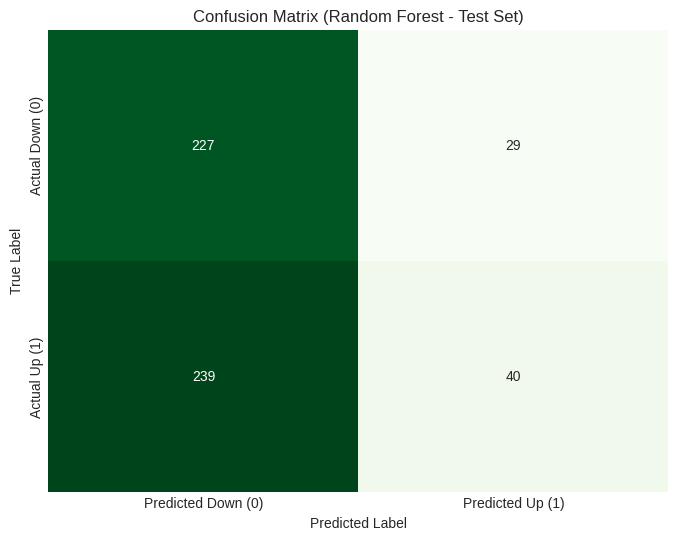


--- Random Forest Test Set Classification Report ---
                precision    recall  f1-score   support

Price Down (0)       0.49      0.89      0.63       256
  Price Up (1)       0.58      0.14      0.23       279

      accuracy                           0.50       535
     macro avg       0.53      0.52      0.43       535
  weighted avg       0.54      0.50      0.42       535


Random Forest Test Set ROC AUC Score: 0.5352


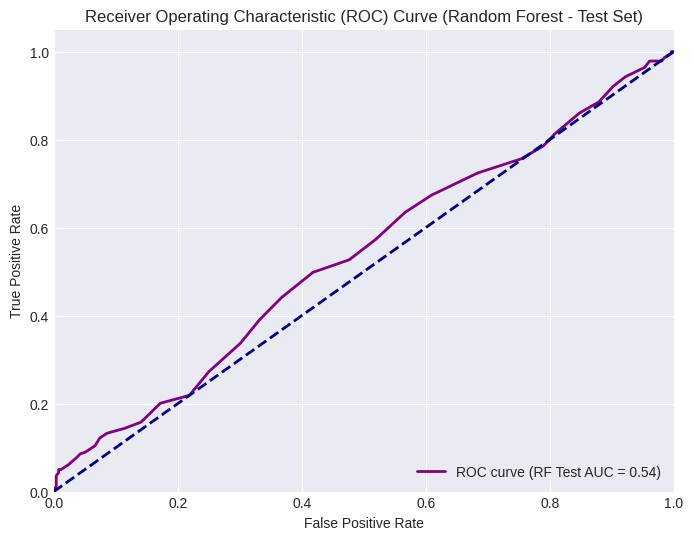


--- RF Baseline Comparison ---
Majority Class Baseline Accuracy (on test set): 0.5215
RF Model Accuracy Improvement over Majority Class Baseline: -0.0224

Note: Evaluate if RF shows any improvement over Logistic Regression and the naive baseline.


In [18]:
# Section 5: Model Evaluation

if 'model' in globals() and X_test.shape[0] > 0 : # Check if model exists and test data is available
    print("\n--- Starting Model Evaluation on Held-Out Test Set ---")

    # 1. Make predictions on the test set
    y_pred_test = model.predict(X_test_scaled)
    y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

    # 2. Evaluate the model
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f"\nTest Set Accuracy: {accuracy_test:.4f}")

    # Check balance of target in test set
    print(f"\nTest set 'Price_Up' distribution:\n{y_test.value_counts(normalize=True)}")

    # Confusion Matrix
    print("\n--- Test Set Confusion Matrix ---")
    cm_test = confusion_matrix(y_test, y_pred_test)
    print(cm_test)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Down (0)', 'Predicted Up (1)'],
                yticklabels=['Actual Down (0)', 'Actual Up (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # Classification Report
    print("\n--- Test Set Classification Report ---")
    print(classification_report(y_test, y_pred_test, target_names=['Price Down (0)', 'Price Up (1)']))

    # ROC AUC Score
    try:
        roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
        print(f"\nTest Set ROC AUC Score: {roc_auc_test:.4f}")

        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Test AUC = {roc_auc_test:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve (Test Set)')
        plt.legend(loc="lower right")
        plt.show()
    except ValueError as e:
        print(f"\nCould not calculate ROC AUC or plot ROC curve for test set: {e}")

    # --- Compare to Baseline --
    print("\n--- Baseline Comparison ---")
    baseline_accuracy = y_test.value_counts(normalize=True).max() # Majority class baseline
    print(f"Majority Class Baseline Accuracy (on test set): {baseline_accuracy:.4f}")
    print(f"Model Accuracy Improvement over Majority Class Baseline: {(accuracy_test - baseline_accuracy):.4f}")
    print("\nNote: The model's performance is still close to random chance, even with additional features and class balancing. Financial markets are notoriously hard to predict.")

else:
    print("Skipping Model Evaluation as the model or test data is not available.")

# --- 5b. Model Evaluation for Random Forest on Held-Out Test Set ---

if 'rf_model' in globals() and X_test_scaled.shape[0] > 0 : # Check if rf_model exists and test data is available
    print("\n\n--- Starting Random Forest Model Evaluation on Held-Out Test Set ---")

    # 1. Make predictions on the test set
    y_pred_test_rf = rf_model.predict(X_test_scaled)
    y_pred_proba_test_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

    # 2. Evaluate the model
    accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
    print(f"\nRandom Forest Test Set Accuracy: {accuracy_test_rf:.4f}")

    # Confusion Matrix for Random Forest
    print("\n--- Random Forest Test Set Confusion Matrix ---")
    cm_test_rf = confusion_matrix(y_test, y_pred_test_rf)
    print(cm_test_rf)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test_rf, annot=True, fmt='d', cmap='Greens', cbar=False, # Changed cmap for distinction
                xticklabels=['Predicted Down (0)', 'Predicted Up (1)'],
                yticklabels=['Actual Down (0)', 'Actual Up (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Random Forest - Test Set)')
    plt.show()

    # Classification Report for Random Forest
    print("\n--- Random Forest Test Set Classification Report ---")
    print(classification_report(y_test, y_pred_test_rf, target_names=['Price Down (0)', 'Price Up (1)']))

    # ROC AUC Score for Random Forest
    try:
        roc_auc_test_rf = roc_auc_score(y_test, y_pred_proba_test_rf)
        print(f"\nRandom Forest Test Set ROC AUC Score: {roc_auc_test_rf:.4f}")

        fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_test_rf)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'ROC curve (RF Test AUC = {roc_auc_test_rf:.2f})') # Changed color
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve (Random Forest - Test Set)')
        plt.legend(loc="lower right")
        plt.show()
    except ValueError as e:
        print(f"\nCould not calculate ROC AUC or plot ROC curve for Random Forest test set: {e}")

    # --- Compare RF to Baseline --
    print("\n--- RF Baseline Comparison ---")
    # baseline_accuracy should be defined from Logistic Regression evaluation part
    print(f"Majority Class Baseline Accuracy (on test set): {baseline_accuracy:.4f}")
    print(f"RF Model Accuracy Improvement over Majority Class Baseline: {(accuracy_test_rf - baseline_accuracy):.4f}")
    print("\nNote: Evaluate if RF shows any improvement over Logistic Regression and the naive baseline.")

else:
    print("Skipping Random Forest Model Evaluation as the model or test data is not available.")


--- Starting Model Interpretability ---

--- Feature Coefficients (Importance) from Logistic Regression ---
             Feature  Coefficient
4        Close_Lag_7    -0.492019
9        MA_Close_30     0.228942
1        Close_Lag_1     0.192787
0         Log_Volume     0.169754
6       Close_Lag_14    -0.140031
10      Daily_Return    -0.119014
5   Log_Volume_Lag_7    -0.112201
11         MACD_Hist    -0.077456
2        Close_Lag_3     0.072541
7         MA_Close_7     0.049464
3   Log_Volume_Lag_3    -0.033363
8        MA_Close_14    -0.004243


<ipython-input-19-2b3e86ec064f>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(20), palette='viridis') # Show top 20


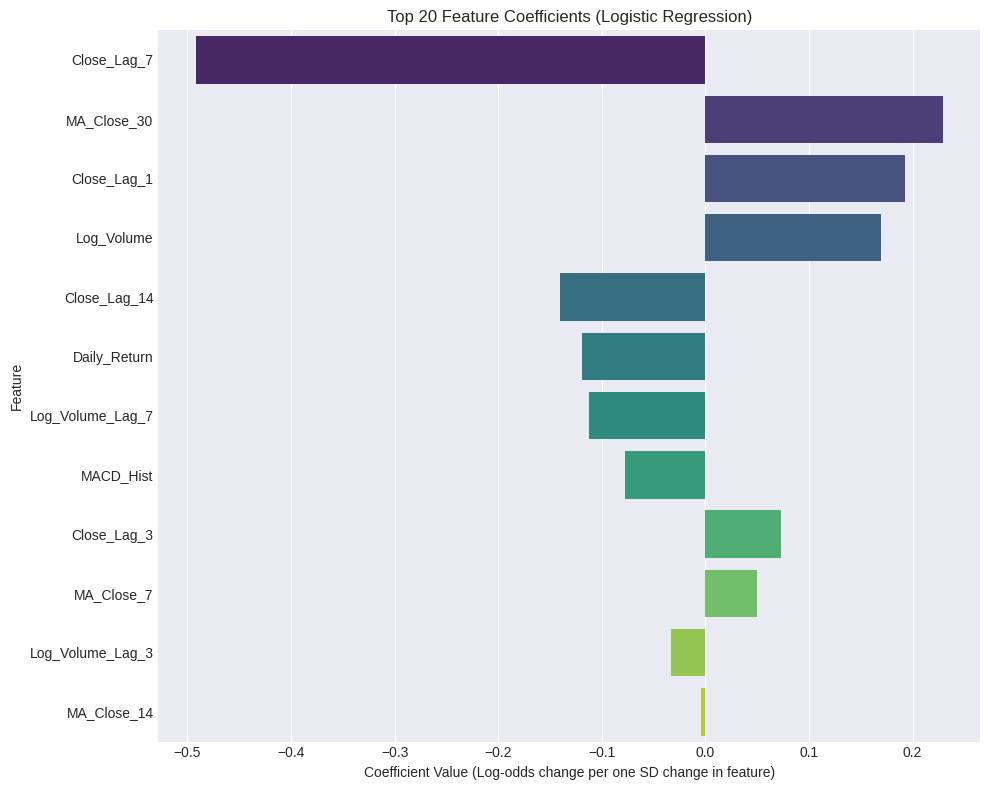


Interpretation of Coefficients:
- Positive coefficient: An increase in this feature's value increases the log-odds (and thus probability) of Price_Up = 1.
- Negative coefficient: An increase in this feature's value decreases the log-odds (and thus probability) of Price_Up = 1.
- Magnitude indicates the strength of influence (on scaled data).

Insight: Features like MA_Close_14 (if still positive and strong) suggest medium-term trends are considered predictive, which could enhance CryptoNest.io’s predictive signals, while negative coefficients like Close_Lag_7 (if still negative and strong) indicate short-term mean-reversion effects useful for risk management or signal generation.


--- Starting Random Forest Model Interpretability ---

--- Random Forest Feature Importances ---
             Feature  Importance
10      Daily_Return    0.103249
3   Log_Volume_Lag_3    0.094516
5   Log_Volume_Lag_7    0.090758
11         MACD_Hist    0.090394
0         Log_Volume    0.090115
6       Close

<ipython-input-19-2b3e86ec064f>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_feature_importance_df.head(20), palette='mako') # Changed palette


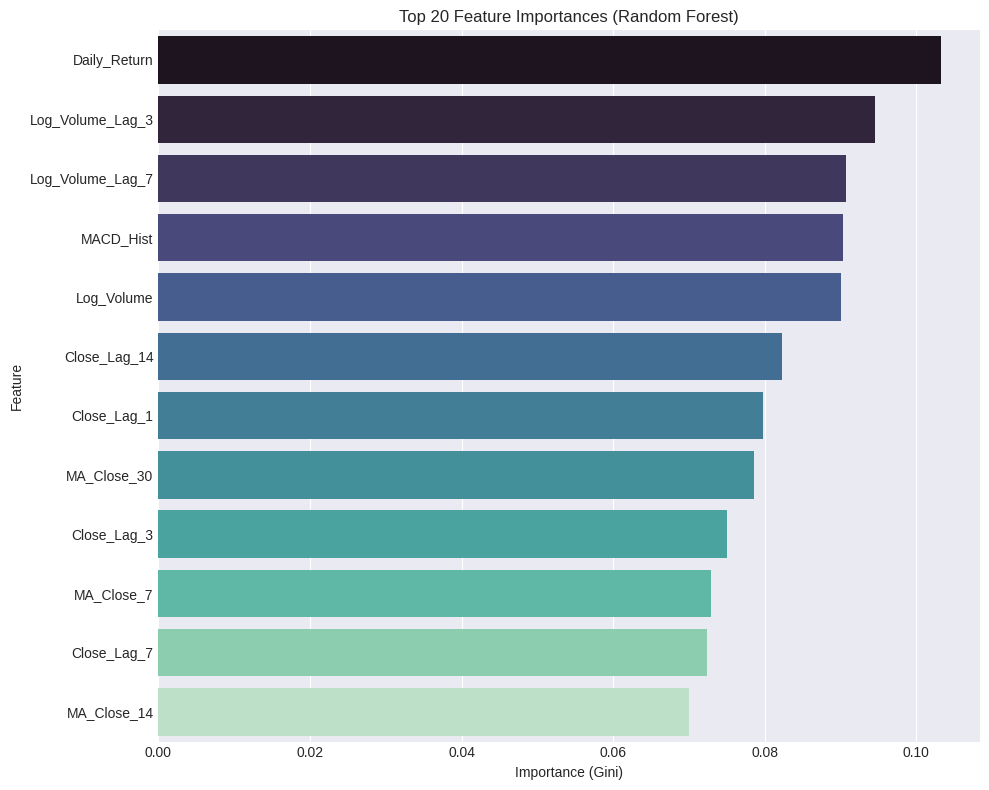


Interpretation of Random Forest Feature Importances:
- Higher importance value indicates the feature was more decisive in splitting nodes in the trees.
- Unlike Logistic Regression coefficients, these don't directly show direction (positive/negative) of impact on 'Price_Up',
  but rather the overall contribution to the model's predictive power.

Insight: Compare these with Logistic Regression coefficients. RF might pick up on non-linear relationships or different feature interactions.
For example, if RSI or MACD-related features show higher importance in RF, it might indicate their non-linear predictive value for CryptoNest.io.


In [19]:
# Section 6: Interpretability (Feature Importance for Logistic Regression)

if 'model' in globals() and 'X_train' in globals() and not X_train.empty:
    print("\n--- Starting Model Interpretability ---")

    try:
        coefficients = model.coef_[0]
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': coefficients
        })
        feature_importance_df['Absolute_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
        feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False).drop(columns=['Absolute_Coefficient'])

        print("\n--- Feature Coefficients (Importance) from Logistic Regression ---")
        print(feature_importance_df.to_string())

        plt.figure(figsize=(10, 8)) # Adjusted for potentially more features
        sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(20), palette='viridis') # Show top 20
        plt.title('Top 20 Feature Coefficients (Logistic Regression)')
        plt.xlabel('Coefficient Value (Log-odds change per one SD change in feature)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

        print("\nInterpretation of Coefficients:")
        print("- Positive coefficient: An increase in this feature's value increases the log-odds (and thus probability) of Price_Up = 1.")
        print("- Negative coefficient: An increase in this feature's value decreases the log-odds (and thus probability) of Price_Up = 1.")
        print("- Magnitude indicates the strength of influence (on scaled data).")
        print("\nInsight: Features like MA_Close_14 (if still positive and strong) suggest medium-term trends are considered predictive, which could enhance CryptoNest.io’s predictive signals, while negative coefficients like Close_Lag_7 (if still negative and strong) indicate short-term mean-reversion effects useful for risk management or signal generation.")

    except Exception as e:
        print(f"Could not retrieve or display feature importance: {e}")
else:
    print("Skipping Model Interpretability as the model or training feature data is not available.")

# --- 6b. Interpretability for Random Forest (Feature Importance) ---

if 'rf_model' in globals() and 'X_train' in globals() and not X_train.empty:
    print("\n\n--- Starting Random Forest Model Interpretability ---")

    try:
        # Get feature importance from Random Forest (Gini importance)
        importances_rf = rf_model.feature_importances_

        # Create a DataFrame for better visualization
        rf_feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns, # Use original column names before scaling
            'Importance': importances_rf
        })

        # Sort by importance
        rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

        print("\n--- Random Forest Feature Importances ---")
        print(rf_feature_importance_df.to_string())

        # Plotting feature importances for Random Forest
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=rf_feature_importance_df.head(20), palette='mako') # Changed palette
        plt.title('Top 20 Feature Importances (Random Forest)')
        plt.xlabel('Importance (Gini)')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

        print("\nInterpretation of Random Forest Feature Importances:")
        print("- Higher importance value indicates the feature was more decisive in splitting nodes in the trees.")
        print("- Unlike Logistic Regression coefficients, these don't directly show direction (positive/negative) of impact on 'Price_Up',")
        print("  but rather the overall contribution to the model's predictive power.")
        print("\nInsight: Compare these with Logistic Regression coefficients. RF might pick up on non-linear relationships or different feature interactions.")
        print("For example, if RSI or MACD-related features show higher importance in RF, it might indicate their non-linear predictive value for CryptoNest.io.")


    except Exception as e:
        print(f"Could not retrieve or display Random Forest feature importance: {e}")
else:
    print("Skipping Random Forest Model Interpretability as the model or training feature data is not available.")

